<a href="https://colab.research.google.com/github/Akshatasthana18/Celebal25/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import kagglehub

path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kdd-cup-1999-data


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [25]:
col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count",
    "srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]
dataset_path = "/root/.cache/kagglehub/datasets/galaxyh/kdd-cup-1999-data/versions/1"
file_name = "kddcup.data_10_percent_corrected"


In [26]:
df = pd.read_csv(os.path.join(dataset_path, file_name), names=col_names)

df["attack"] = df["label"].apply(lambda x: 0 if x == 'normal.' else 1)

In [27]:
X = df.drop(columns=["label", "attack"])
y = df["attack"]

In [28]:
categorical = ["protocol_type", "service", "flag"]
numerical = X.drop(columns=categorical).columns.tolist()

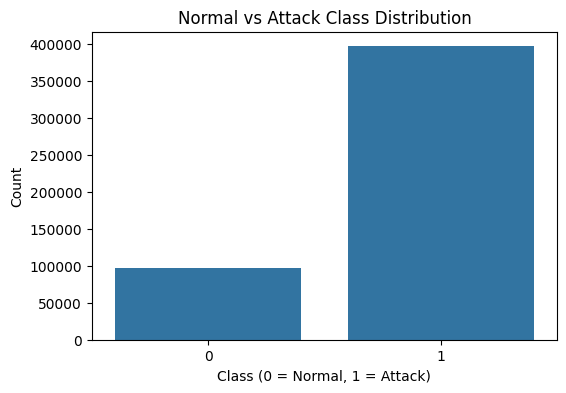

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x='attack', data=df)
plt.title("Normal vs Attack Class Distribution")
plt.xlabel("Class (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()


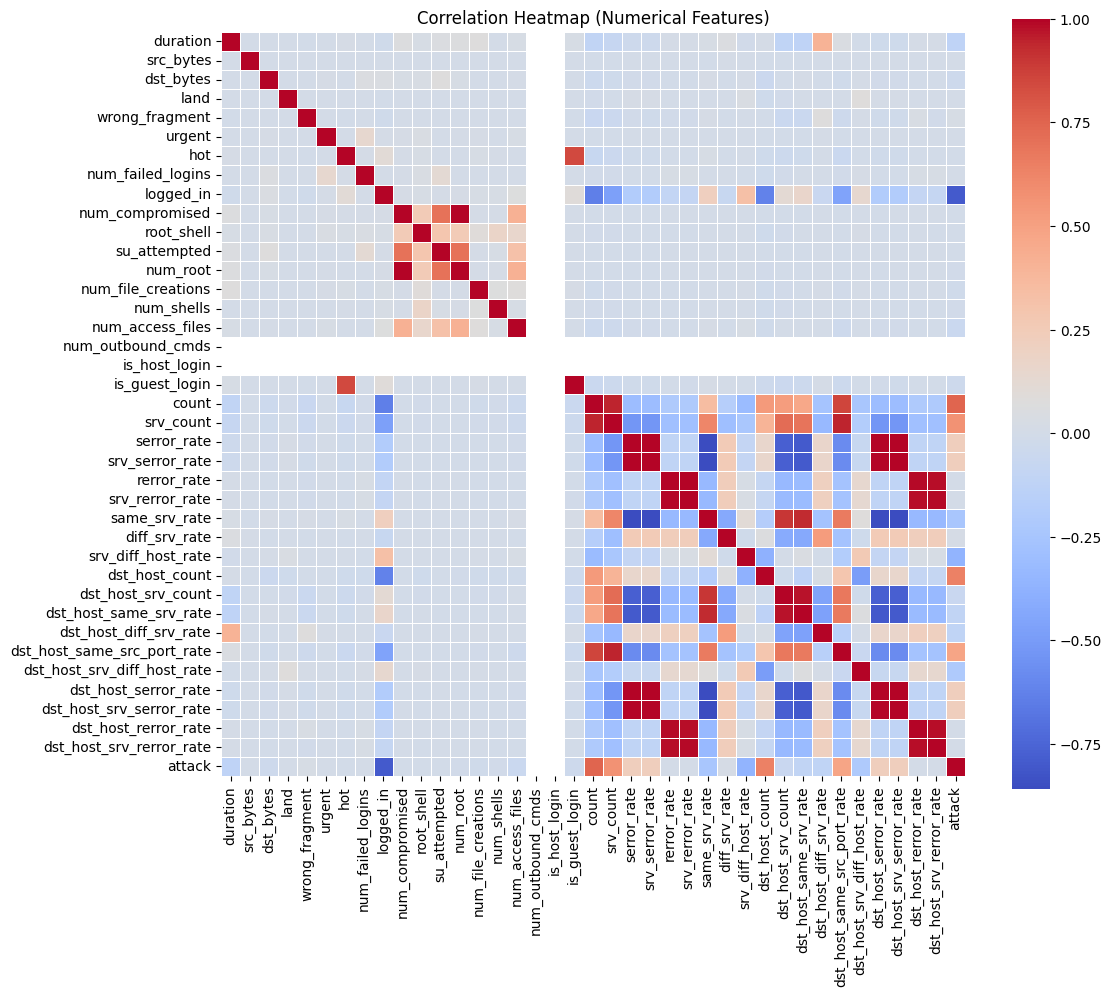

In [30]:
plt.figure(figsize=(12, 10))
corr = df[numerical + ['attack']].corr()
sns.heatmap(corr, cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


In [31]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ]
)


In [32]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('iso_forest', IsolationForest(n_estimators=100, contamination=0.1, random_state=42))
])

X_sample, _, y_sample, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)


pipeline.fit(X_sample)

preds = pipeline.named_steps["iso_forest"].predict(
    pipeline.named_steps["preprocess"].transform(X_sample)
)


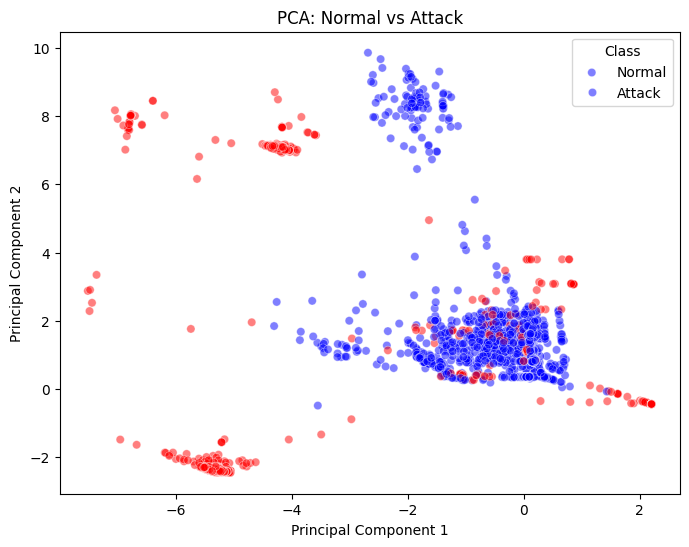

In [33]:

X_scaled = preprocessor.fit_transform(X_sample)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette=['blue', 'red'], alpha=0.5)
plt.title("PCA: Normal vs Attack")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", labels=["Normal", "Attack"])
plt.show()


In [34]:
preds = np.where(preds == 1, 0, 1)

In [35]:
print("\n📊 Classification Report:")
print(classification_report(y_sample, preds, target_names=["Normal", "Attack"]))


📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.18      0.80      0.29      1969
      Attack       0.61      0.08      0.14      8031

    accuracy                           0.22     10000
   macro avg       0.39      0.44      0.21     10000
weighted avg       0.53      0.22      0.17     10000

